In [1]:
if True: # enable folding code
    if False:
        from julia.api import Julia
        jl = Julia(compiled_modules=False)

    import julia; julia.install(quiet=True)
    from julia import Main

    import numpy as np
    import sympy as sp
    from IPython.display import display, Math

    np.set_printoptions(precision=3, suppress=True)

    try:
        from scipy.linalg import cholesky, eigh, qz, ordqz
        HAVE_SCIPY = True
    except Exception as e:
        HAVE_SCIPY = False
        print("SciPy not available; QZ and ordqz demos will be skipped:", e)

    def residual(A,B,lam,x):
        num = np.linalg.norm(A@x - lam*(B@x))
        den = (np.linalg.norm(A)*np.linalg.norm(x) + 1e-15)
        return num/den

In [2]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [3]:
%%julia
using Pkg
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
using GenLinAlgProblems, LinearAlgebra, BlockArrays, RowEchelon, LaTeXStrings, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix");
# -------------------------------------------------------------------------------------------------------
function naive_householder( A; tol = :none )
    # naive implementation from HouseholderRlections.ipynb
    e = eltype(A)
    if tol == :none tol = zero(e) end

    function sgn(x)
        x != zero(e) ? sign(x) : one(e)
    end

    m,n = size(A)
    AI  = [copy(A) one(e)I(m)]

    matrices = [ [:none, AI ] ]

    i = 1; j = 1
    while i < m && j <= n
        v         = AI[:,j]                                  # original vector
        v[1:i-1] .= zero(e)                                  # keep only the part of the vector we are working with
        len_v     = sqrt(v'v)
        if (len_v - abs(v[i])) > tol                         # non-zero values below current pivot position
            ṽ     = zeros(e,m); ṽ[i] = - sgn(v[i]) * len_v   # reflected vector (if v[j] = 0, we set the sign to 1)

            w     = v + ṽ                                    # bisector
            Q     = I(m) - 2*w*w' / (w'w)                    # reflection matrix  (note this assumes v ≠ 0)
            AI    = Q*AI                                     # update the matrix

            push!(matrices, [Q, copy(AI)] )
            i += 1
        end
        j += 1
    end

    return matrices
end;

  Activating project at `C:\Users\jeff\NOTEBOOKS\elementary-linear-algebra\GenLinAlgProblems`


<div style="height:2cm;">
<div style="float:center;width:100%;text-align:center;"><strong style="height:100px;color:darkred;font-size:40px;">Generalized Eigenvalue Computation</strong>
</div></div>

# 1. Introduction

This notebook addresses numerical methods for solving the generalized eigenproblem (GEP):  
$\qquad \displaystyle{ A \mathbf{v} = \lambda B \mathbf{v} }$

The focus is on algorithmic strategies for computing eigenvalues and eigenvectors,  
particularly in structured cases where $A$ and $B$ are symmetric, and $B$ is positive definite.  
Structured solvers are contrasted with general-purpose routines suitable for arbitrary pencils.

Topics include:

- Solvers for symmetric-definite pencils
- Treatment of general matrix pencils
- Sensitivity to conditioning and numerical roundoff
- Interpretation of computed eigenpairs

The theoretical foundation, including variational formulations and physical interpretations,  
is presented in the preceding notebook: [**GEP_intro.ipynb**](GEP_intro.ipynb).

# 2. Symmetric-Definite Case

Consider the generalized eigenproblem  
$\qquad \displaystyle{ A x = \lambda B x}$  
where both matrices $A$ and $B$ are real symmetric, and $B$ is **positive definite**,  
i.e., $A=A^T$, $B=B^T \succ 0$

**Remark:** when $B$ is invertible, we may convert the GEP to a standard eigenproblem:  
$\qquad A x = \lambda B x \;\Leftrightarrow\; B^{-1} A x = \lambda x$.  
$\qquad$ Numerically however, forming $B^{-1} A$ explicitly is **dangerous** when $B$ is ill-conditioned;
it also destroys structure.  

$\qquad$ We will therefore formulate an algorithm that avoids inverting $B$ using the Cholesky Factorization.

____

Since $B$ is symmetric positive definite, it admits a **Cholesky decomposition**:  
$\qquad \displaystyle{ B = L^T L }$  
where $L$ is upper triangular with positive diagonal entries.

Substituting into the generalized eigenproblem:  
$\qquad \displaystyle{ A x = \lambda\ L^T L x }$

Let $\;\; \displaystyle{ x = L^{-1} z }$, then  
$\qquad \displaystyle{
\begin{aligned}
A x = \lambda B x 
\quad &\Leftrightarrow\quad A L^{-1} z = \lambda L^T L L^{-1} z \\
     &\Leftrightarrow\quad A L^{-1} z = \lambda L^T z \\
     &\Leftrightarrow\quad (L^T)^{-1} A L^{-1} z = \lambda z
\end{aligned}
}$

Define $\;\; \displaystyle{ \tilde{A} = (L^T)^{-1} A L^{-1} }$.  
Then the problem reduces to the standard eigenproblem:  
$\qquad \displaystyle{ \tilde{A} z = \lambda z }$

Once the eigenpairs $(\lambda, z)$ are computed, the original eigenvectors are obtained by  
$\qquad \displaystyle{ x = L^{-1} z }$

**Remark:** **explicit computation of** $\displaystyle{ L^{-1} }$ **or** $\displaystyle{ (L^T)^{-1} }$ **should be avoided in practice**.
- To evaluate $\displaystyle{x = L^{-1} z }$, compute $z$ via forward substitution (i.e., solve $L x = z$)
- To apply the transformation $\displaystyle{ \tilde{A} = (L^T)^{-1} A L^{-1} }$,
  solve two triangular systems rather than forming the inverse

#### **Algorithm Summary**

1) Compute $L$ (Cholesky factorization of $B$).  
2) Form $\tilde A = L^{-1} A L^{-T}$ by triangular solves.  
3) Compute eigenpairs $(\lambda, z)$ of the symmetric matrix $\tilde A$.  
4) Recover $x = L^{-T} z$; optionally $B$-normalize: $x \leftarrow x/\sqrt{x^T B x}$.

In [4]:
def gep_symmetric_definite(A,B):
    """Solve A x = λ B x for symmetric A and SPD B via Cholesky whitening.
    Returns (lam, X) with columns of X being B-normalized eigenvectors.
    """
    if not HAVE_SCIPY:
        raise RuntimeError("SciPy required here for robust Cholesky/eigh.")
    L = cholesky(B, lower=True)
    # Solve for At = L^{-1} A L^{-T}
    At = np.linalg.solve(L, A)
    At = At @ np.linalg.solve(L.T, np.eye(A.shape[0]))
    lam, Z = eigh(At)
    # Map back and B-normalize
    X = np.linalg.solve(L.T, Z)
    for i in range(X.shape[1]):
        xi = X[:,i]
        nB = np.sqrt(xi.T @ B @ xi)
        if nB > 0:
            X[:,i] = xi / nB
    return lam, X

#### **Example**

In [5]:
def sym_pos_def_demo():
    #np.random.seed(0)
    n = 5
    R = np.random.randn(n,n)
    B = R@R.T + n*np.eye(n)       # SPD
    S = np.random.randn(n,n)
    A = 0.5*(S+S.T)
    lam, X = gep_symmetric_definite(A,B)

    A_rep = sp.latex(sp.Matrix(np.round(A,2)), mat_str='pmatrix', mat_delim=None)
    B_rep = sp.latex(sp.Matrix(np.round(B,2)), mat_str='pmatrix', mat_delim=None)
    display(Math("A = " + A_rep + r",\quad B = " + B_rep))

    print("\nEigenvalues (symmetric-definite route):", lam)
    print("\n    ||X^T B X - I||         = ", np.linalg.norm(X.T @ B @ X - np.eye(n)))
    print("    ||A X - B X diag(lam)|| = ", np.linalg.norm(A@X - B@X@np.diag(lam)))
sym_pos_def_demo()

<IPython.core.display.Math object>


Eigenvalues (symmetric-definite route): [-0.339 -0.099  0.023  0.033  0.119]

    ||X^T B X - I||         =  1.957451994442827e-15
    ||A X - B X diag(lam)|| =  2.6544177236017644e-15


# 3. General Case

## 3.1 Matrices in Generalized Schur Form

<div style="background-color:#F2F5A9;color:black;">

**Definition:**  A pair $(S,T)$ is in **(real, quasi-) generalized Schur form**<br>
$\qquad$ if both are block upper triangular with the **same** block pattern<br>
$\qquad$ and each diagonal block is either $1\times1$ or $2\times2$.

The generalized eigenproblem for $(S,T)$ is $\;\; S x=\lambda\,T x$.
</div>

**This immediately yields eigenvalues:**  
Since $(S,T)$ are triangular by blocks, $\det(S-\lambda T)$ factors over the diagonal blocks:
- For a $1\times1$ block $([s_{ii}],[t_{ii}])$, eigenvalue $\,\lambda_i=s_{ii}/t_{ii}$ (finite if $t_{ii}\neq 0$, infinite if $t_{ii}=0$).
- For a $2\times2$ block $(S_{kk},T_{kk})$, the two eigenvalues are the roots of
<br>$\qquad \det(S_{kk}-\lambda T_{kk})=0$.

**This yields eigenvectors.**  
Fix an eigenvalue $\lambda$. Solve the homogeneous system
<br>$\qquad (S-\lambda T)x=0$
by **block back substitution**:
- If the trailing active block is $1\times1$, pick and normalize $x_i$, then solve upward.
- If it is $2\times2$, solve $(S_{kk}-\lambda T_{kk})\,x_{[k:k+1]}=0$, then continue upward.
Left eigenvectors satisfy $w^\top S=\lambda\, w^\top T$ and are obtained the same way on the transposed pair.

#### Example

Consider
$\;\;
S=\left(\begin{array}{rrrr}
\color{red}4&\color{red}7&5&6\\
\color{red}{-4}&\color{red}{-2}&3&8\\
0&0&\color{red}6&2\\
0&0&0&\color{red}{-3}
\end{array}\right),\quad
T=\begin{pmatrix}
\color{red}2&\color{red}1&4&3\\
\color{red}0&\color{red}2&7&5\\
0&0&\color{red}2&1\\
0&0&0&\color{red}1
\end{pmatrix}\;\;
$ with the 3 blocks shown in red.

**Eigenvalues.**
- Leading $2\times2$ block $\;\;S_{1} = \left(\begin{array}{rr} 4&7 \\ {-4}&{-2}\\ \end{array}\right), \;\;
T_{1} = \begin{pmatrix} 2 & 1 \\ 0 & 2\end{pmatrix}$

$\qquad \det\!\big(S_{1}-\lambda T_{1}\big)=4(\lambda^2-2\lambda+5)=0
\;\Rightarrow\; \lambda=1\pm 2i.$
- $1\times1$ blocks $\;\;S_2=\begin{pmatrix}6\end{pmatrix},\;\; T_2 = \begin{pmatrix}2\end{pmatrix}\;\;$ and
$S_3=\begin{pmatrix}-3\end{pmatrix},\;\; T_3 = \begin{pmatrix}1\end{pmatrix}\;\;$

$\qquad \lambda_3=6/2=3,\quad \lambda_4=-3/1=-3.$

**Right eigenvectors (Schur basis).** For each listed $\lambda$, solve
<br>$\qquad (S-\lambda T) x = 0$
by back substitution as above:

$\qquad
x_{1-2i} =
\left(\begin{array}{c}
-1 + i\\
1\\
0\\
0
\end{array}\right),
\;\;
x_{1+2i} =
\left(\begin{array}{c}
-1 - i\\
1\\
0\\
0
\end{array}\right),
\;\;
x_{3} =
\left(\begin{array}{r}
-16\\
-1\\
4\\
0
\end{array}\right),
\;\;
x_{-3} =
\left(\begin{array}{r}
59\\
-97\\
-20\\
48
\end{array}\right).
$

## 3.2 The A = RQ Factorization

A QR Factorization may be used to obtain a RQ factorization of a matrix

Let $J=\begin{pmatrix} 0&\cdots&0&\color{red}1\\ 0&\cdots&\color{red}1&0\\ \vdots & \ddots&\vdots&\vdots\\ \color{red}1&0&\cdots&0 \end{pmatrix}\;\;$
be the reversal (permutation) matrix, i.e. $J$ flips the order of rows (or columns).

Because $J$ is orthogonal we have $J^{T}=J^{-1}=J$.

We may is this matrix to obtain a factorization $A = \tilde{A}\ \tilde{Q}$,<br>
where $\tilde{A}$ is upper triangular and $\tilde{Q}$ is orthogonal (or unitary)<br>
as follows:

Starting from the QR factorisation of the reflected transpose $J^{T}A^{T}J = Q R$,
we obtain <br>
$\qquad \begin{align}
J^T A^T J = Q R\quad  & \Leftrightarrow \quad A^T  = J Q J^T J R J^T  & \\
                & \Leftrightarrow \quad A^T  = \tilde{Q} \tilde{R} \qquad\qquad \text{ where }                               \tilde{Q} = J Q J^T, \tilde{R} = J R J^T \\
                & \Leftrightarrow \quad A = \tilde{R}^T \tilde{Q}^T &
\end{align}$

### 3.2.1  Example: $A = \tilde{R} \tilde{Q}$

In [207]:
%%julia
function naive_rq( M; name=nothing)
    P = 1I(size(M, 1))[end:-1:1, :]
    M̃ = P * transpose(M) * P
    qr_fact = qr(M̃)

    Qt = Matrix(qr_fact.Q)             # orthogonal factor (explicit dense matrix)
    Rt = Matrix(qr_fact.R)             # upper‑triangular factor (explicit dense matrix)

    B = P * transpose(Rt) * P
    C = P * transpose(Qt) * P

    if ! isnothing(name)
        display(py_show( "Decompose ", name, " = ", Int.(M), L",\quad J = ", P, L",\quad \text{ so }\; J ", name, " J = ", Int.(M̃)))
    end

    B, C
end

function test_naive_rq()
    A = [4.0 1.0 2.0; 2.0 3.0 1.0; 1.0 0.0 2.0]

    R,Q = naive_rq(A; name="A")
    println()
    display(py_show( L"A = RQ, \text{ where } R \approx ", R, L"\quad Q \approx ", Q, number_formatter=x->round_value(x,2)))
    println("Check:")
    @show (B ≈ R*Q); flush(stdout)
    @show transpose(Q)*Q ≈ I;
end
test_naive_rq();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


Check:
trueR * Q = 
transpose(Q) * Q ≈ I = true


### 3.2.2 $A = RQ$ one Column at a Time

We will need to zero out entries in a matrix one column at a time.<br>
To do so, we have to zero out entries in a row to the left of a given position in transformed space.

Below a naive reference implementation using Householder transformations to zero out entries<br>
$\qquad$ **one column at a time**

In [208]:
%%julia
@doc """
householder_vector(x::AbstractVector; target::Symbol = :first) -> Vector

Computes a Householder vector `v` such that the reflection 
    `Q = I - 2vvᵀ` maps `x` to a vector aligned with the `target` coordinate.

Arguments:
- `x`: A vector to be reflected.
- `target`: `:first` (default) aligns with the first coordinate; `:last` aligns with the last.

Returns:
- A unit Householder vector `v` such that `Qx` has all zeros except possibly one entry.
"""
function householder_vector(x::AbstractVector; target::Symbol = :first)
    x = vec(x)
    if all(iszero, x)
        return zeros(eltype(x), length(x))
    end

    σ        = norm(x)
    e        = zeros(eltype(x), length(x))
    index    = target == :first ? 1 : length(x)
    e[index] = sign(x[index]) == 0 ? σ : sign(x[index]) * σ

    v     = x - e
    vnorm = norm(v)

    if vnorm ≈ 0
        return zeros(eltype(x), length(x))
    end

    result = v / vnorm
    return result
end
# --------------------------------------------------------------------------------------------
@doc """
zero_left_of_entry!(A::Matrix{Float64}, i::Int, j::Int) -> Matrix

Applies a Householder reflection **from the right** to zero out entries
to the **left** of `A[i,j]` in row `i`, i.e., `A[i, 1:j-1]`.

This modifies `A` in place as `A ← A * Z`, where `Z` is orthogonal.

Arguments:
- `A`: Matrix to be modified in-place.
- `i`: Row index of the pivot element.
- `j`: Column index of the pivot (last element to preserve).

Returns:
- The orthogonal matrix `Z` applied from the right.
"""
function zero_left_of_entry!(A::Matrix{Float64}, i::Int, j::Int)
    n = size(A, 2)

    x     = copy(@view A[i, 1:j])
    v_sub = householder_vector(x; target = :last)

    v       = zeros(eltype(A), n)
    v[1:j] .= v_sub

    Z = I - 2 * (v * v')
    A .= A * Z

    return Z
end

# --------------------------------------------------------------------------------------------
@doc """
zero_below_entry_right!(A::Matrix{Float64}, i::Int, j::Int) -> Matrix

Applies a Householder transformation from the **right** to zero out entries
**below** the element `A[i,j]` in column `j`.

This is achieved by flipping and transposing `A` to convert the operation
into a left-side transformation.

Arguments:
- `A`: A square matrix (modified in-place).
- `i`: Row index of the pivot.
- `j`: Column index of the pivot (entries below this in column `j` are zeroed).

Returns:
- The orthogonal matrix `Z` such that `A ← A * Z` zeros below `A[i,j]`.
"""
function rz_zero_below_entry!(A::Matrix{Float64}, i::Int, j::Int)
    m = size(A, 1)

    # Flip and transpose
    Jm = reverse(Matrix{Float64}(I, m, m), dims=1)
    Ã = Jm * transpose(A) * Jm

    ĩ = m - j + 1
    j̃ = m - i + 1
    Z̃ = zero_left_of_entry!(Ã, ĩ, j̃)

    # Unflip and untranspose
    A .= Jm * transpose(Ã) * Jm
    Z  = Jm * transpose(Z̃) * Jm

    return Z
end
;

In [203]:
%%julia
# test decomposition on a random matrix of size n x n
function test_rz_decomposition(n::Int = 3)
    A      = randn(n, n)
    A_orig = copy(A)

    display(py_show("original matrix A = ", A, number_formatter = x -> round(x, digits=2)))

    Z_total = Matrix{Float64}(I, n, n)

    for j in 1:n-1
        Zj       = rz_zero_below_entry!(A, j, j)
        Z_total = Z_total * Zj # Accumulate Z = Z₁ Z₂ ⋯
        display(py_show("zeros in column $j", L"\quad\;", A, number_formatter = x -> round(x, digits=2)))
    end

    R = A
    Z = Z_total

    display(py_show("A = R Z = ", R, Z, number_formatter = x -> round(x, digits=2)))

    #@show norm(A_orig - R * Z) ;flush(stdout)
    #@show norm(A_orig - R * Z') ;flush(stdout)
    @show norm(A_orig - Z*R) ;flush(stdout)
    #@show norm(A_orig - Z'*R) ;flush(stdout)
    @show norm(Z' * Z - I) ;flush(stdout)
end

# Run the test
test_rz_decomposition(4)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

norm(A_orig - Z * R) = 1.182791486138611e-15
norm(Z' * Z - I) = 1.0761492355705496e-15


**Remarks:**
* Since $R$ is lower triangular, $\tilde{R}$ is upper triangular.
* Since $\tilde{Q}^T \tilde{Q} = \left( J Q^T J^T\right) \left( J Q J^T \right) = I$, the matrix $\tilde{Q}$ is orthogonal
* Note that for complex matrices $A$, the computation requires **the transpose of $A$** rather than the hermitian transpose.

## 3.3 The Generalized Schur (QZ) Decomposition

The QZ algorithm reduces a matrix pencil $(A,B)$ to its generalized (quasi-)Schur form $(S,T)$,<br>
$\qquad$ in which the generalized eigenvalues are read directly from the diagonal blocks.<br>
$\qquad$ It preserves the spectrum and records transformations so that eigenvectors can be recovered from $(S,T)$.

The **QZ algorithm** generalizes the [**Schur decomposition**](Schur_Decomposition.ipynb).

It obtains two orthogonal (or unitary) matrices $Q$ and $Z$ such that<br>
$\qquad S = Q^H A Z$ and $T = Q^H B Z = T$, where $(S,T)$

The spectrum is preserved, and the transformations $Q,Z$ allow recovery of eigenvectors from $(S,T)$:

$\qquad 
\begin{align}
A x = \lambda B x \quad & \Leftrightarrow \quad  Q A Z Z^T\ x = \lambda\ Q B Z Z^T\ x & \\
                        & \Leftrightarrow \quad  Q A Z \ \tilde{x} = \lambda\ Q B Z \ \tilde{x} \qquad\qquad & \text{ where } \tilde{x} = Z^T x
\end{align}$

Hence $(\lambda, x)$ is a generalized eigenpair of $ A x = \lambda B x$<br>
if and only if $( \lambda, Z^T x )$ is a generalized eigenpair of $ Q A Z \ \tilde{x} = \lambda \ Q B Z\ \tilde{x}$

### 3.2.1 Example Pencil

We will introduce the algorithm using the following two matrices:

In [6]:
%%julia
A = [3.0 2.0 1.0; 2.0 3.0 4.0; 1.0 5.0 6.0]
B = [4.0 1.0 2.0; 2.0 3.0 1.0; 1.0 0.0 2.0]
py_show("Let A = ", A, L",\quad B = ", B, number_formatter=x->round_value(x,0))

<IPython.core.display.Latex object>

### 3.2.3 The QZ Algorithm

In [57]:
%%julia
# --------------------------------------------------------------------------------------------------------------------------
""" Column reduction helper  zero out column below A[i,j]
using a Householder reflection
"""
function apply_column_householder(AI::Matrix{T}, i::Int, j::Int) where T
    e = eltype(AI)
    function sgn(x)  x != zero(e) ? sign(x) : one(e) end

    m = size(AI, 1)
    v = AI[:, j]
    v[1:i-1] .= zero(T)                     # Zero out the upper part (above pivot)
    len_v = sqrt(v'v)

    if len_v ≈ abs(v[i])
        return nothing                      # No transformation needed
    end

    ṽ    = zeros(T, m)
    ṽ[i] = -sgn(v[i]) * len_v               # Reflected vector

    w = v + ṽ                               # Householder vector
    Q = I(m) - 2 * (w * w') / (w' * w)      # Householder matrix

    return Q * AI, Q                        # Return updated matrix and reflector
end

#    e = eltype(A)
#    AI = [copy(A) one(e) * I(m)]

# --------------------------------------------------------------------------------------------------------------------------
"""
RQ‑style “triangularize” step on a trailing block of B.
Given B_block of size m×n (n ≥ m), returns (Q_block, R_block) such that
Q_block' * B_block = R_block is upper triangular in the first column (i.e. zeroes below).
"""
function rq_triangularize_step(B_block::Matrix{Float64})
    n = size(B_block, 1)
    x = B_block[:, 1]                   # first column of the active block
    normx = norm(x)
    if normx == 0
        return 1.0Matrix(I, n, n), B_block
    end

    e1 = zeros(n); e1[1] = normx * sign(x[1])
    v = x - e1
    v /= norm(v)

    Q = I - 2 * (v * v')                # Householder reflector
    B_new = Q' * B_block                # zero below first entry in column 1
    return Q, B_new
end

# --------------------------------------------------------------------------------------------------------------------------
"""
Performs a one-column Hessenberg-style reduction (QR step) on A.

Zeros out A[k+2:end, k] by applying a Householder reflector from the right.

Returns:
- Z (full n×n orthogonal matrix),
- A_new = A * Z

Only modifies columns k+1 onward.
"""
function right_hessenberg_step(A::Matrix{Float64}, k::Int)
    n = size(A, 1)

    println("\n------------------------- Hessenberg Step k = $k -------------------------------")
    # Flip the matrix inside‑out using the true transpose
    J = reverse(Matrix{Float64}(1.0I, n, n), dims=1)
    Ã = J * transpose(A) * J
    #display(py_show("A = ", A, " Flipped A = ", Ã, number_formatter =x->round(x,digits=3)))

    R̃, Q̃ = apply_column_householder(  Ã, k+1, k)
    # display(py_show( R̃, Q̃,  number_formatter =x->round(x,digits=3)))

    if Q̃ !== nothing
        Z = J * transpose(Q̃) * J
        A = J * transpose(R̃) * J
    else
        Z = Matrix{Float64}(1.0I, n, n)
    end

    #display(py_show("Z  ", Q̃, ", ", Z, number_formatter =x->round(x,digits=2)))
    #display(py_show("final ", R̃, A, number_formatter =x->round(x,digits=2)))
    return A, Z
end
# ===================================================================================================================
# ===================================================================================================================
using Random

function test_rq_triangularize_step(n=5)
    # random B_block with more columns than rows
    m=n
    B_block = randn(m, n)
    Qb, Rb  = rq_triangularize_step(B_block)
    # Check orthogonality Qb
    errQ = norm(Qb' * Qb - I(m))
    # Check that Qb' * B_block = Rb
    errR = norm(Qb' * B_block - Rb)
    # Check first column of Rb has zeros below the first entry
    col1 = Rb[:, 1]
    errZero = norm(col1[2:end])
    println("rq test: orth err = $errQ, reconstruction err = $errR, subcolumn zeros err = $errZero")
py_show(Qb, Rb, number_formatter=x->round(x,digits=3))
end

function test_right_hessenberg_step()
    n = 5
    A = randn(n,n)
    Ai = copy(A)
    Z = Matrix{Float64}(1.0I, n, n)
    for i in 1:n-2
        Ai, Zi = right_hessenberg_step(Ai, i)
        Z = Z * Zi
    end
    display(py_show( "A -> ", Ai, ",  using Z = ", Z,  number_formatter =x->round(x,digits=3)))
    Ai ≈ A*Z
end
# --------------------------------------------------------------------------------------------------------------------------
function run_tests()
    test_rq_triangularize_step()
    test_right_hessenberg_step()
end
# --------------------------------------------------------------------------------------------------------------------------
run_tests()

<IPython.core.display.Latex object>

rq test: orth err = 4.825976119234165e-16, reconstruction err = 0.0, subcolumn zeros err = 3.6648793514595844e-16

------------------------- Hessenberg Step k = 1 -------------------------------

------------------------- Hessenberg Step k = 2 -------------------------------

------------------------- Hessenberg Step k = 3 -------------------------------

<IPython.core.display.Latex object>

True

In [22]:
%%julia
###############################################################
#  QZ step 1  –  Hessenberg‑triangular reduction (safe version)
###############################################################
using LinearAlgebra

#--------------------------------------------------------------
# 1.  Safe Householder vector
#--------------------------------------------------------------
using LinearAlgebra

function householder_vector(x::AbstractVector)
    x = vec(x)
    @show x

    if all(iszero, x)
        @info "x is all zeros — returning identity vector"
        return zeros(eltype(x), length(x))
    end

    σ = norm(x)
    @show σ

    e1 = zeros(eltype(x), length(x))
    e1[1] = sign(x[1]) == 0 ? σ : sign(x[1]) * σ
    @show e1

    v = x - e1
    @show v

    vnorm = norm(v)
    @show vnorm

    if vnorm ≈ 0
        @info "v is zero — returning identity vector"
        return zeros(eltype(x), length(x))
    end

    result = v / vnorm
    @show result

    return result
end

#--------------------------------------------------------------
householder_matrix(v::AbstractVector) = I - 2*(v*v')

#--------------------------------------------------------------
# 2.  Left reflector  →  zero A[j+2:end,j]
#--------------------------------------------------------------
function apply_left_householder!(A, B, j)
    m = size(A, 1)
    if j+1 >= m
        @info "Skipping left reflector at j=$j — bottom row"
        return I
    end

    @info "Building LEFT reflector at j=$j"
    x = A[j+1:end, j]
    @show x

    v_sub = householder_vector(x)
    @show v_sub

    v = zeros(eltype(A), m)
    v[j+1:end] .= v_sub
    @show v

    Q = I - 2 * (v * v')
    A[:] = Q * A
    B[:] = Q * B

    return Q
end

#--------------------------------------------------------------
# 3.  Right reflector  →  zero B[j+1,j+2:end]
#--------------------------------------------------------------
function apply_right_householder!(A::Matrix{Float64}, B::Matrix{Float64}, j::Int)
    n = size(B, 1)

    if j+1 >= n
        @info "⏩ Skipping right reflector at column j = $j (nothing below diagonal)"
        return Matrix{Float64}(I, n, n)
    end

    println("\n🔹 APPLY RIGHT HOUSEHOLDER at column j = $j")

    # Step 1: Flip-transpose-flip the matrix to simulate a right reflector as a left one
    J = reverse(Matrix{Float64}(I, n, n), dims=1)
    B̃ = J * transpose(B) * J

    # Step 2: Identify the row in B̃ corresponding to column j in B
    # Due to flipping, column j in B corresponds to row n - j + 1 in B̃
    row = n - j + 1

    # Extract the row to reflect — we want to zero out everything except the last entry
    x = B̃[row, :]

    # Step 3: Construct a Householder reflector that maps x to ±‖x‖ · eₙ (last basis vector)
    σ = norm(x)
    if σ ≈ 0
        @info "    All-zero row — skipping reflector"
        return Matrix{Float64}(I, n, n)
    end

    e_n = zeros(n); e_n[end] = 1.0
    v = x - σ * e_n
    v /= norm(v)

    Q̃ = I - 2 * (v * v')  # Householder reflector in flipped space

    # Step 4: Convert Q̃ back to a right reflector in original space
    Z = J * transpose(Q̃) * J

    # Step 5: Apply Z to A and B from the right
    A[:] = A * Z
    B[:] = B * Z

    # Diagnostics
    println("   ⇒ ‖B[j+1:end, j]‖ = ", round(norm(B[j+1:end, j]), digits=6))
    println("   ⇒ B[:, $j] = ", round.(B[:, j], digits=4))

    return Z
end

function apply_column_householder(M::Matrix{Float64}, col::Int, start_row::Int)
    m, n = size(M)
    if start_row > m
        return M, nothing
    end

    x = M[start_row:end, col]
    if norm(x) ≈ 0
        return M, nothing
    end

    v = householder_vector(x)
    v_full = zeros(m)
    v_full[start_row:end] .= v

    Q = I - 2 * (v_full * v_full')  # Householder reflector
    R = Q * M

    return R, Q
end


#--------------------------------------------------------------
# 4.  Step 1 driver
#--------------------------------------------------------------
function qz_step1(A::AbstractMatrix{T}, B::AbstractMatrix{T}) where T<:Real
    A = Float64.(A)
    B = Float64.(B)
    n = size(A, 1)

    Qacc = Matrix{Float64}(I, n, n)
    Zacc = Matrix{Float64}(I, n, n)

    for j in 1:n-2
        @info "=== Step j = $j ==="

        Qj = apply_left_householder!(A, B, j)
        Qacc = Qj * Qacc
display(py_show(j, ": left ", A, B, number_formatter=x->round(x,digits=2)))
        Zj = apply_right_householder!(A, B, j)
display(py_show(j, ": right ", A, B, number_formatter=x->round(x,digits=2)))
        Zacc = Zacc * Zj
    end

    return A, B, Qacc, Zacc
end

###############################################################
#  Example
###############################################################
A = [
    5  2  -1   0;
    3  4   1   2;
    1 -1   3   1;
    2  0   2   4
]

B = [
    2  1  0  0;
    3  5  1  0;
    1  2  4  1;
    2  1  0  3
]

H, T, Q, Z = qz_step1(A,B)
flush(stdout)
println("A (≈ Hessenberg)")
display(round.(H, digits=4))
println("B (≈ Upper‑triangular)")
display(round.(T, digits=4))
println("‖QᵀQ − I‖ =", norm(Q'Q - I))
println("‖ZᵀZ − I‖ =", norm(Z'Z - I))

println("B = ", B)

function is_upper_triangular(M; atol=1e-12)
    m, n = size(M)
    for i in 2:m
        for j in 1:i-1
            if abs(M[i,j]) > atol
                println("  ⚠️  B[$i,$j] = ", M[i,j])
                return false
            end
        end
    end
    return true
end
@show is_upper_triangular(T)

py_show( "A_hess = ", H, ", B_tri = ", T, number_formatter =x->round(x,digits=3))


[ Info: === Step j = 1 ===
[ Info: Building LEFT reflector at j=1


x = [3.0, 1.0, 2.0]
[3.0, 1.0, 2.0]
σ = 3.7416573867739413
e1 = [3.7416573867739413, 0.0, 0.0]
v = [-0.7416573867739413, 1.0, 2.0]
2.355855615133566
result = [-0.3148144487334776, 0.42447423075344315, 0.8489484615068863]
v_sub = [-0.3148144487334776, 0.42447423075344315, 0.8489484615068863]
v = [0.0, -0.3148144487334776, 0.42447423075344315, 0.8489484615068863]


<IPython.core.display.Latex object>


🔹 APPLY RIGHT HOUSEHOLDER at column j = 1
6.499427j+1:end, j]‖ = 
[1.8247, 6.2422, 1.6711, 0.6965]

<IPython.core.display.Latex object>

[ Info: === Step j = 2 ===
[ Info: Building LEFT reflector at j=2


x = [-0.20242190864798928, -1.347652858878042]
[-0.20242190864798928, -1.347652858878042]
1.362770287738493
[-1.362770287738493, 0.0]
v = [1.1603483790905038, -1.347652858878042]
vnorm = 1.7783634580422865
result = [0.65248100653613, -0.7578050779122549]
v_sub = [0.65248100653613, -0.7578050779122549]
v = [0.0, 0.0, 0.65248100653613, -0.7578050779122549]

<IPython.core.display.Latex object>



🔹 APPLY RIGHT HOUSEHOLDER at column j = 2
2.375928j+1:end, j]‖ = 
   ⇒ B[:, 2] = [1.1603, 5.4186, -2.1091, 1.0939]


<IPython.core.display.Latex object>

A (≈ Hessenberg)
B (≈ Upper‑triangular)
‖QᵀQ − I‖ =5.039089557117841e-16
‖ZᵀZ − I‖ =6.792774964743483e-16
B = [2 1 0 0; 3 5 1 0; 1 2 4 1; 2 1 0 3]
  ⚠️  B[2,1] = 3.458060084615214
is_upper_triangular(T) = false


<IPython.core.display.Latex object>

#### Step 1: Initial Reduction (Optional)

The first stage in the QZ algorithm applies orthogonal transformations to reduce the matrix pair $(A, B)$  
to a structured intermediate form:
- $A$ is reduced to **upper Hessenberg form** (zero entries below the first subdiagonal),
- $B$ is reduced to **upper triangular form**.

That is, orthogonal matrices $Q_1$ and $Z_1$ are constructed such that:  
$\qquad \displaystyle{ A_1 = Q_1^T A Z_1 }$ is upper Hessenberg  
$\qquad \displaystyle{ B_1 = Q_1^T B Z_1 }$ is upper triangular

* $Q_1$ acts from the left to annihilate entries of $A$ using a QR algorithm  
typically performed using a sequence of [**Householder reflections**](HouseholderReflections.ipynb) or [**Givens Rotations**](GivensRotations.ipynb)  
* $Z_1$ acts from the right to eliminate subdiagonal entries in $B$ using an RQ algorithm as described above.

The same transformations $Q_1$ and $Z_1$ are applied to both $A$ and $B$ to preserve the structure of the generalized eigenproblem.

No assumption is made about symmetry or definiteness of $A$ or $B$.  
The process applies to any square matrices of the same size.

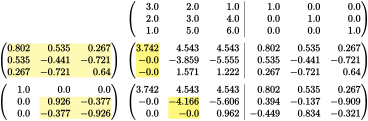

In [8]:
%%julia
matrices = naive_householder(A)
A₁       = matrices[end][2][:,1:size(A,2)]
Q₁       = matrices[end][2][:,size(A,2)+1:end]'
B₁       = Q₁ * B
h,_=nM.ge( matrices, formater=a -> string(round(a,digits=3)), Nrhs=size(A,1),
    bg_for_entries=[
        [1, 0, [[(0, 0), (2, 2)]], "yellow!30"],[1, 1, [[(0, 0), (2, 0)]], "yellow!50"],
        [2, 0, [[(1, 1), (2, 2)]], "yellow!30"],[2, 1, [[(1, 1), (2, 1)]], "yellow!50"],
    ],
    tmp_dir="/tmp")
h

In [9]:
%%julia
py_show(L"Q_1 = ", Q₁, L"\quad A_1 = Q_1 A = ", A₁, L"\quad B_1 = Q_1 B = ", B₁, number_formatter=x->round_value(x,3))

<IPython.core.display.Latex object>

In [9]:
%%julia
A = [3.0 2.0 1.0 4.0;
     2.0 3.0 4.0 1.0;
     1.0 5.0 6.0 -1.0;
     1.0 2.0 1.0 3.0
]

B = [4.0 1.0 2.0 4.0;
     2.0 3.0 1.0 1.0;
     1.0 5.0 2.0 2.0;
    -1.0 3.0 1.0 4.0]
#Z,BZ = right_householder_from_row(B, 1)
Z,BZ=right_reflector_for_column(B,1)
py_show(Z, BZ, B*Z, number_formatter=x->round_value(x,2))

RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: UndefVarError: `right_reflector_for_column` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Stacktrace:
 [1] top-level scope
   @ none:14
 [2] eval
   @ .\boot.jl:430 [inlined]
 [3] eval
   @ .\Base.jl:130 [inlined]
 [4] (::var"#13#14")(globals::PyObject, locals::PyObject)
   @ Main C:\Users\jeff\AppData\Local\Programs\Python\Python311\Lib\site-packages\julia\pyjulia_helper.jl:91
 [5] (::PyCall.FuncWrapper{Tuple{PyObject, PyObject}, var"#13#14"})(::PyObject, ::Vararg{PyObject}; kws::@Kwargs{})
   @ PyCall C:\Users\jeff\.julia\packages\PyCall\1gn3u\src\callback.jl:56
 [6] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::@Kwargs{})
   @ Base .\essentials.jl:1055
 [7] invokelatest(::Any, ::Any, ::Vararg{Any})
   @ Base .\essentials.jl:1052
 [8] _pyjlwrap_call(f::PyCall.FuncWrapper{Tuple{PyObject, PyObject}, var"#13#14"}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
   @ PyCall C:\Users\jeff\.julia\packages\PyCall\1gn3u\src\callback.jl:28
 [9] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
   @ PyCall C:\Users\jeff\.julia\packages\PyCall\1gn3u\src\callback.jl:44>

#### Step 2: Hessenberg–Triangular Reduction

The first stage reduces $A$ to upper Hessenberg form and $B$ to upper triangular form:  
$\qquad \displaystyle{ Q_1^T A Z_1 = H }, \qquad \displaystyle{ Q_1^T B Z_1 = R }
$

This can be done via a sequence of **Householder transformations**, similar to the QR algorithm.

#### Step 3: Iterative QZ Step

Next, an iterative process analogous to the QR algorithm is applied:
- A shift $\sigma$ is selected
- The matrix $A - \sigma B$ is implicitly factorized as $QR$
- Update:
  $\; \displaystyle{ A \leftarrow R Q + \sigma, \quad B \leftarrow Q^T B Q }$

Each iteration reduces the subdiagonal structure while maintaining the triangular form of $B$.

The process is repeated until both $A$ and $B$ are simultaneously triangular (or quasi-triangular in the complex case).

---

### Step 4: Eigenvalue Extraction

Once in triangular form  
$\qquad \displaystyle{ S = Q^T A Z }, \quad \displaystyle{ T = Q^T B Z }
$
the eigenvalues of the pencil $A - \lambda B$ are given by  
$\qquad \displaystyle{ \lambda_i = \frac{s_{ii}}{t_{ii}} }, \quad \text{for } t_{ii} \neq 0
$

Infinite or indeterminate eigenvalues may arise if $t_{ii} = 0$.

---

### Summary

- The QZ algorithm generalizes the Schur decomposition by reducing a matrix pair $(A, B)$ to triangular form via orthogonal transformations.
- The process maintains numerical stability and avoids explicit inversion.
- Eigenvalues are obtained from the resulting triangular pencil $(S, T)$.
- Left and right eigenvectors may be computed from the accumulated transformations.

This algorithm is implemented in LAPACK as `xGGEV` and accessed in SciPy via `scipy.linalg.eig`.

For full details, see:
- Golub & Van Loan, *Matrix Computations*, 4th ed., Chapter 7

Let $(A, B)$ be a pair of square matrices of the same size.  
The **generalized Schur decomposition**, also known as the **QZ decomposition**, expresses both matrices in an upper-triangular form via orthogonal (or unitary) similarity transformations.

There exist orthogonal matrices $Q$ and $Z$ such that
$\qquad \displaystyle{ Q^T A Z = S }, \quad \displaystyle{ Q^T B Z = T }$  
where $S$ and $T$ are both upper (quasi-)triangular matrices.

This defines the **generalized Schur form** of the pencil $(A, B)$.

The original generalized eigenproblem  
$\qquad \displaystyle{ A x = \lambda B x }$  
is transformed into the equivalent problem  
$\qquad \displaystyle{ S \hat{x} = \lambda T \hat{x} }$  
with $\hat{x} = Z^{-1} x$.

The generalized eigenvalues are given (formally) as:
$\qquad \displaystyle{ \lambda_i = \frac{s_{ii}}{t_{ii}} }$  
for each $i$ such that $t_{ii} \neq 0$.

If $t_{ii} = 0$ and $s_{ii} \neq 0$, then $\lambda_i = \infty$.  
If both $s_{ii}$ and $t_{ii}$ are zero, the eigenvalue is considered **undefined** or **indeterminate**, and may signal a singular pencil.

---

### Properties

- The eigenvalues of the pencil $(A, B)$ are invariant under the transformation.
- If $A$ and $B$ are both real, then $Q$, $Z$, $S$, and $T$ can be taken as real.
- If the matrices are complex, then $Q$ and $Z$ are unitary.
- The decomposition is **backward stable** and suitable for arbitrary (nonsymmetric, indefinite, or singular) pencils.

---

### Comparison with the Standard Schur Decomposition

- The **standard Schur decomposition** reduces a single matrix to triangular form:  
  $\qquad \displaystyle{ A = Q S Q^T }$
- The **generalized Schur decomposition** reduces a matrix *pair* to simultaneous triangular form via two-sided transformations:
  $\qquad \displaystyle{ (A, B) \mapsto (S, T) = (Q^T A Z, Q^T B Z) }$

This generalization is necessary because no single transformation can, in general, triangularize both $A$ and $B$ simultaneously unless they commute, which is rare in practice.

For arbitrary regular $(A,B)$, compute unitary $Q,Z$ such that  
$\qquad Q^T A Z = S, \quad Q^T B Z = T,$  
with $S,T$ (quasi)upper-triangular. This is the **generalized Schur form**.

- **Eigenvalues** are read from diagonal blocks as ratios $\qquad \lambda_i = S_{ii}/T_{ii}$ (with $T_{ii}=0$ encoding $\lambda_i=\infty$).  
- The orthogonal/unitary steps make QZ **backward stable**: computed results are exact for a nearby $(A+\Delta A,B+\Delta B)$ with small perturbations.

In [ ]:
def qz_eigs(A,B,output='real'):
    if not HAVE_SCIPY:
        raise RuntimeError("SciPy required for QZ.")
    S, T, Q, Z = qz(A, B, output=output)
    alpha = np.diag(S).astype(complex)
    beta  = np.diag(T).astype(complex)
    w = alpha / beta
    return w, (S,T,Q,Z)

# Small demo with a nonsymmetric pair
A = np.array([[4., 2., 0.],
              [1., 3., 1.],
              [0., 0., 2.]])
B = np.array([[1., 0., 0.],
              [0., 2., 0.],
              [0., 0., 1.]])

if HAVE_SCIPY:
    w, (S,T,Q,Z) = qz_eigs(A,B,output='real')
    print("QZ eigenvalues (ratios S_ii/T_ii):", np.real(w))
    # Residual check with right Schur vectors (columns of Z span invariant subspaces)
    for i in range(len(w)):
        x = Z[:,i]
        print(f"i={i}, residual:", np.round(residual(A,B,w[i],x), 3))
else:
    print("SciPy not available; skipping QZ demo.")

# 4. Detecting $\lambda=\infty$ in practice

In QZ form, $T_{ii}\approx 0$ indicates $\lambda_i=\infty$ (since $\lambda_i=S_{ii}/T_{ii}$). Equivalently, flip to the **reciprocal pencil**
$\qquad B - \mu A $
and look for eigenvalues at $\mu=0$.


In [ ]:
# Example: regular pencil with B singular -> one eigenvalue at infinity
A = np.array([[1., 0.],
              [0., 2.]])
B = np.array([[1., 0.],
              [0., 0.]])

if HAVE_SCIPY:
    w1, (S1,T1,_,Z1) = qz_eigs(A,B,output='real')
    print("Eigenvalues of (A,B):", w1, "  (one should be ∞)")
    print("T diag:", np.diag(T1))  # one ~0
    # Reciprocal
    w2, _ = qz_eigs(B,A,output='real')
    print("Eigenvalues of reciprocal (B,A):", w2, "  (expect a zero)")
else:
    print("SciPy not available; ∞-eigenvalue demo skipped.")

# 5. Reordering and deflating subspaces (via `ordqz`)

To extract a **deflating subspace** for a spectral region (e.g., $|\lambda|<1$ for discrete-time stability), reorder the generalized Schur form so that the desired eigenvalues appear first. The corresponding first columns of $Z$ span the deflating subspace.

In [ ]:
if HAVE_SCIPY:
    # Discrete-time example: select |lambda| < 1
    A = np.array([[0.8, 0.3, 0.0],
                  [0.0, 1.2, 0.2],
                  [0.0, 0.0, 0.9]])
    B = np.eye(3)

    def select_inside(alpha, beta):
        w = alpha/beta
        return np.abs(w) < 1.0

    S, T, Q, Z, alpha, beta, sdim = ordqz(A, B, sort=select_inside, output='real')
    w = alpha/beta
    print("Reordered eigenvalues:", w)
    print("Count inside unit disk:", sdim)
    # Extract deflating subspace U = Z[:, :sdim] and verify approximate invariance
    U = Z[:, :sdim]
    PA = U @ np.linalg.lstsq(U, (A@U), rcond=None)[0]
    PB = U @ np.linalg.lstsq(U, (B@U), rcond=None)[0]
    print("||A U - Proj_U(A U)||:", np.linalg.norm(A@U - PA))
    print("||B U - Proj_U(B U)||:", np.linalg.norm(B@U - PB))
else:
    print("SciPy not available; ordqz demo skipped.")


# 6. Backward error viewpoint and residual auditing

A computed pair $(\hat\lambda, \hat x)$ satisfies $A\hat x - \hat\lambda B \hat x = r$. With QZ (orthogonal/unitary updates), the algorithm is **backward stable**: it computes the exact Schur form of a nearby pencil $(A+\Delta A, B+\Delta B)$ with small perturbations.

**Practical check.** Report **normalized residuals**  
$\qquad \dfrac{\|A\hat x - \hat\lambda B\hat x\|}{\|A\|\,\|\hat x\|}$  
for all computed modes; small residuals give confidence in the solution.

In [ ]:
# Residual audit on a random example
np.random.seed(7)
A = np.random.randn(6,6)
B = np.random.randn(6,6)

if HAVE_SCIPY:
    w, (S,T,Q,Z) = qz_eigs(A,B,output='complex')
    res = np.array([residual(A,B,w[i],Z[:,i]) for i in range(len(w))])
    print("Median normalized residual:", np.median(res))
    print("Max normalized residual   :", np.max(res))
else:
    print("SciPy not available; residual audit skipped.")

# 7. Practical recipes and pitfalls

- **If $A=A^T$, $B=B^T \succ 0$**: use the **Cholesky route** (symmetric-definite). You get real eigenvalues and $B$-orthonormal eigenvectors.  
- **Otherwise (regular pencils)**: use **QZ**; read eigenvalues from $S_{ii}/T_{ii}$, detect $\lambda=\infty$ via $T_{ii}\approx 0$.  
- **Never form $B^{-1}A$ explicitly**; prefer triangular solves or Schur/QZ.  
- **Scale/equilibrate** poorly scaled inputs before solving (see Notebook 3).  
- **Always check residuals**; when in doubt, verify with multiple methods (e.g., Cholesky vs QZ) in cases where both apply.

# 8. Exercises

1) **Symmetric-definite route.** Create random SPD $B$ and symmetric $A$; solve via whitening and verify $X^T B X \approx I$ and $AX \approx BX\Lambda$.  
2) **QZ reading.** Construct a pair with a singular $B$; use QZ to detect $T_{ii}\approx 0$ and confirm the presence of $\lambda=\infty$ using the reciprocal pencil.  
3) **Reordering.** For a discrete-time model $(A,E)$, use `ordqz` to separate $|\lambda|<1$ modes and verify the deflating subspace property numerically.  
4) **Backward error.** For a random pencil, compute all residuals and relate their magnitudes to problem scaling (try equilibrating $A,B$ first).  
5) **Structure check.** For the symmetric-definite case, compare eigenvalues from the Cholesky route with those from QZ (they should agree to roundoff).

# Take Away

<div style="display: flex; margin-top: 1em; margin-bottom: 1em;">
<!-- ----------------------------------------- Python box -->
<div style="width: 22em; height: 4.8em; padding-right: 1cm;
            background: #f8f8f8; border: 1px solid #ccc; border-radius: 4px;
            font-family: monospace; font-size: 90%; line-height: 1.2;
            display: flex; align-items: flex-start; padding: 0.6em 0.75em;
            box-sizing: border-box;">
  <div>
    <div style="font-weight: bold; margin-bottom: 0.2em;">Python</div>
    <div>U, _ = np.linalg.qr(A)</div>
    <div>V, _ = np.linalg.qr(B)</div>
  </div>
</div>
<!-- ---------------------------------------- Julia box -->
<div style="width: 22em; height: 4.8em; margin-left: 1cm;
            background: #f8f8f8; border: 1px solid #ccc; border-radius: 4px;
            font-family: monospace; font-size: 90%; line-height: 1.2;
            display: flex; align-items: flex-start; padding: 0.6em 0.75em;
            box-sizing: border-box;">
  <div>
    <div style="font-weight: bold; margin-bottom: 0.2em;">Julia</div>
    <div>U = qr(A).Q</div>
    <div>V = qr(B).Q</div>
  </div>
</div>
</div>

In [21]:
P      = np.fliplr(np.eye(Main.A.shape[0]))   # permutation that flips order
Qt, Rt = np.linalg.qr(P@ Main.A.T @ P)        # Qt orthogonal, Rt upper‑triangular
B = P @ Rt.T @ P                              # upper‑triangular
C = P @ Qt.T @ P                              # orthogonal

In [22]:
Main.A - B @ C

array([[ 0.,  0.,  0.,  0.],
       [ 0., -0., -0.,  0.],
       [ 0.,  0.,  0., -0.],
       [ 0.,  0.,  0.,  0.]])

# Why the QZ (Generalized Schur) Algorithm Works

## 1.  The Generalized Eigenvalue Problem
Given two square matrices $A,B\in\mathbb{R}^{n\times n}$ (or $\mathbb{C}^{n\times n}$),
the **pencil eigenproblem** seeks scalars $\lambda$ and non‑zero vectors
$x$ such that
$$
A\,x = \lambda\,B\,x .
\tag{1}
$$
Equivalently, $\lambda$ is a root of $\det(A-\lambda B)=0$.

## 2.  Orthogonal (Unitary) Similarities Preserve the Spectrum
For any orthogonal (real) or unitary (complex) matrices $Q,Z$ we have
$Q^{T}Q=I$ and $Z^{T}Z=I$.  Multiplying (1) on the left by $Q^{T}$
and on the right by $Z$ gives
$$
Q^{T}A Z\,\tilde{x}= \lambda\, Q^{T}B Z\,\tilde{x},
\qquad\text{where }\tilde{x}=Z^{T}x .
\tag{2}
$$
Since the map $x\mapsto\tilde{x}=Z^{T}x$ is bijective, $(\lambda,\tilde{x})$ is an
eigenpair of the transformed pencil
$$
\tilde A = Q^{T} A Z,\qquad \tilde B = Q^{T} B Z .
$$
Conversely, any eigenpair of $(\tilde A,\tilde B)$ yields an eigenpair of
$(A,B)$ by the inverse substitution $x = Z\tilde{x}$.  Hence
$$
\sigma_{\text{gen}}(A,B)=\sigma_{\text{gen}}(Q^{T} A Z,\; Q^{T} B Z).
\tag{3}
$$

## 3.  What the Transformations Do

* **Left multiplication** by $Q^{T}$ rotates the **row space**
of both matrices in exactly the same way.
* **Right multiplication** by $Z$ rotates the **column space**
of both matrices in exactly the same way.
* Because the same rotations are applied to **both** members of the
pencil, the **ratio** $A x / B x$ that defines the generalized eigenvalue
remains unchanged.


## 4.  Why Orthogonal/Unitary Matrices
Orthogonal (unitary) matrices satisfy $Q^{T}=Q^{-1}$ and $Z^{T}=Z^{-1}$;
therefore the transformation in (2) is a genuine **similarity**
transformation of the pencil.  Any invertible $S,T$ would preserve the
generalized eigenvalues, but orthogonal/unitary choices have two crucial
advantages:

1. They are norm‑preserving: $\|Q^{T}A Z\|_{2}=\|A\|_{2}$, which keeps
round‑off errors under control.
2. Their condition number is 1, guaranteeing backward stability of the
algorithm.

## 5.  The QZ Iteration
Starting from a Hessenberg–triangular pencil $(H,T)$ (obtained by an
initial reduction), a single QZ step proceeds as follows:

1. Choose a shift $\sigma$ (typically an eigenvalue of the trailing
$2\times2$ block of $(H,T)$).
2. Form the shifted pencil $(H-\sigma T,\;T)$.
3. Apply a Givens rotation $G_{1}$ from the left to zero the sub‑diagonal
element in the first column of $H-\sigma T$; simultaneously multiply both
$H$ and $T$ on the right by $G_{1}^{T}$.  This creates a **bulge**
below the Hessenberg band.
* Chase the bulge down the matrix with successive Givens rotations,
each applied on the left and on the right, until it exits at the bottom‑right
corner.

Every left/right pair $(G_{k}^{T},\,G_{k})$ is orthogonal, so by (3) the
generalized eigenvalues are unchanged.  After a full sweep the trailing
$2\times2$ block becomes (quasi‑)triangular; repeating the sweep drives the
entire pencil to the generalized Schur form
$$
Q^{T} A Z = S,\qquad Q^{T} B Z = T,
$$
with $S$ quasi‑upper‑triangular and $T$ upper‑triangular.  The eigenvalues
are then simply the ratios of corresponding diagonal (or $2\times2$ block)
entries:
$$
\lambda_{i}= \frac{s_{ii}}{t_{ii}}\quad\text{(or the ratio of the
eigenvalues of matching $2\times2$ blocks).}
$$

## 6.  Summary

* Simultaneous left and right orthogonal transformations constitute a
similarity transformation of the matrix pencil, leaving its generalized
eigenvalues invariant.
* The QZ algorithm exploits this property to reshape the pencil
(Hessenberg–triangular $\to$ quasi‑Schur) while preserving the spectrum.
* Orthogonal (unitary) matrices guarantee numerical stability because
they do not amplify norms or condition numbers.
